In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt
import yfinance as yf

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## load data

In [4]:
filenames = os.listdir('stocks/')

In [5]:
# df = pd.DataFrame()
values_list = []
for file in filenames:
    df = pd.read_csv("stocks/" + file)
    values = df['Close'].values
    for val in values:
        values_list.append(val)

In [9]:
len(values_list)

9949500

In [10]:
df = pd.DataFrame({"Close":values_list})

In [11]:
df.to_csv("combined_data.csv",index=False)

In [3]:
df = pd.read_csv("combined_data.csv")

In [4]:
df = df[:99000]

In [6]:
model = Sequential()

batch_size = 40

model.add(LSTM(units=128, return_sequences=True,input_shape=(60,1)))  #batch_input_shape=(batch_size,60,1)
model.add(Dropout(0.2))
model.add(LSTM(units=64,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.compile(optimizer="adam",loss='mean_squared_error')



## data preprocessing

In [7]:
prediction_days = 60



scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(df.values.reshape(-1,1))

def scale(scaled_data):
    x_train = []
    y_train = []
    
    for x in range(prediction_days,len(scaled_data)):
        x_train.append(scaled_data[x-prediction_days:x,0])
        y_train.append(scaled_data[x,0])

    x_train, y_train = np.array(x_train), np.array(y_train)
    x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
    
    return x_train,y_train


In [8]:
scaled_data.shape[0]

99000

In [30]:
for epoch in range(5):
    for i in range(0, scaled_data.shape[0],3300):
        x, y = scale(scaled_data[i:i+3300])
        print(i)
        print(i+3300)
        print(x.shape,y.shape)

        model.fit(x,y, epochs=1, batch_size=batch_size)
    #     model.reset_states()


0
3300
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 14ms/step - loss: 1.0535e-06
3300
6600
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 11ms/step - loss: 8.8695e-07
6600
9900
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 7.7145e-07
9900
13200
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 6.9607e-07
13200
16500
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 5.7419e-07
16500
19800
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 11ms/step - loss: 5.5448e-07
19800
23100
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 10ms/step - loss: 4.8344e-07
23100
26400
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 11ms/step - loss: 4.6051e-07
26400
29700
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 4.0026e-07
29700
33000
(3240, 60, 1) (3240,)
81/81 [======

81/81 [==============================] - 1s 12ms/step - loss: 3.2254e-08
56100
59400
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 3.2217e-08
59400
62700
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 7.5356e-04
62700
66000
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 1.3622e-05
66000
69300
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 1.5879e-06
69300
72600
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 9.6318e-07
72600
75900
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 5.6315e-07
75900
79200
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 4.0613e-07
79200
82500
(3240, 60, 1) (3240,)
81/81 [==============================] - 1s 12ms/step - loss: 2.9475e-07
82500
85800
(3240, 60, 1) (3240,)
81/81 [==============================

## model accuracy test

In [10]:
test_start = dt.datetime(2000,1,1)
test_end = dt.datetime.now()
company = "GOOG"
test_data = yf.download(company,test_start,test_end)

[*********************100%%**********************]  1 of 1 completed


In [11]:
actual_prices = test_data["Close"].values
# data = pd.read_csv("")
start = dt.datetime(2012,1,1)
end = dt.datetime(2020,1,1)
data = yf.download(company,start,end)

total_dataset = pd.concat([data["Close"],test_data['Close']],ignore_index=True)


model_inputs = total_dataset[len(total_dataset) - len(test_data)-prediction_days:].values


model_inputs = model_inputs.reshape(-1,1)
model_inputs = scaler.transform(model_inputs)

[*********************100%%**********************]  1 of 1 completed


In [12]:
x = 61

model_inputs.shape[0]

4958

## predictions

In [31]:
x_test = []

for x in range(prediction_days,len(model_inputs)):
    x_test.append(model_inputs[x-prediction_days:x, 0])
    
x_test = x_test
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(x_test.shape)
predicted_prices = model.predict(x_test,batch_size=batch_size)
predicted_prices = scaler.inverse_transform(predicted_prices)


(4898, 60, 1)


In [32]:
predicted_prices

array([[ 73.79056 ],
       [ 53.168938],
       [ 26.832693],
       ...,
       [164.84511 ],
       [160.82993 ],
       [155.82674 ]], dtype=float32)

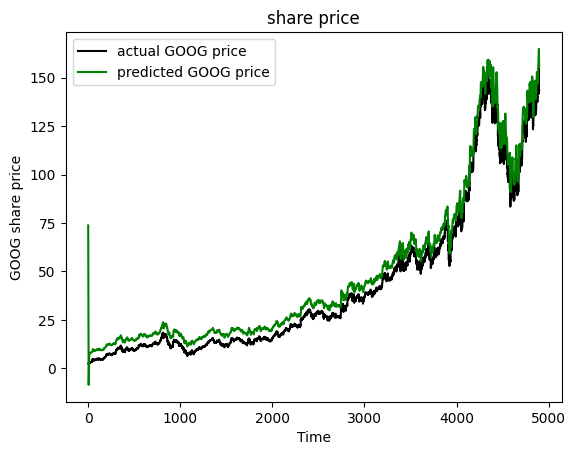

In [33]:
plt.plot(actual_prices,color="black", label=f"actual {company} price")
plt.plot(predicted_prices, color="green", label= f"predicted {company} price")
plt.title("share price")
plt.xlabel('Time')
plt.ylabel(f'{company} share price')
plt.legend()
plt.show()

## predict next day


In [34]:
real_data = [model_inputs[len(model_inputs) - prediction_days:len(model_inputs+1),0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data,(real_data.shape[0],real_data.shape[1],1))

In [39]:
scaler.inverse_transform(model_inputs[-1].reshape(-1,1))

array([[143.53999329]])

In [40]:
prediction = model.predict(real_data[:len(real_data-1)])
prediction = scaler.inverse_transform(prediction)
print(f'prediction: {prediction}')

prediction: [[152.22496]]


In [41]:
actual_prices
predicted_prices

array([[ 73.79056 ],
       [ 53.168938],
       [ 26.832693],
       ...,
       [164.84511 ],
       [160.82993 ],
       [155.82674 ]], dtype=float32)

In [42]:
df = pd.DataFrame(data={"actual": actual_prices.reshape(-1),"predicted":predicted_prices.reshape(-1)} )

In [43]:
df['diff'] = df["actual"] - df["predicted"]

In [44]:
df['actual_comparison'] = ''

# Iterate over rows and compare with the previous row
for i in range(1, len(df)):
    if df['actual'].iloc[i] > df['actual'].iloc[i - 1]:
        df.at[i, 'actual_comparison'] = 'Higher'
    elif df['actual'].iloc[i] < df['actual'].iloc[i - 1]:
        df.at[i, 'actual_comparison'] = 'Lower'

In [45]:
df['predicted_comparison'] = ''

# Iterate over rows and compare with the previous row
for i in range(1, len(df)):
    if df['predicted'].iloc[i] > df['predicted'].iloc[i - 1]:
        df.at[i, 'predicted_comparison'] = 'Higher'
    elif df['predicted'].iloc[i] < df['predicted'].iloc[i - 1]:
        df.at[i, 'predicted_comparison'] = 'Lower'

In [46]:
df["accurate"] = df["actual_comparison"] == df["predicted_comparison"]

In [47]:
df.groupby("accurate").count()

,actual,predicted,diff,actual_comparison,predicted_comparison
accurate,,,,,
False,2436,2436,2436,2436,2436
True,2462,2462,2462,2462,2462


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [8]:
merged_data


,Open_AAPL,High_AAPL,Low_AAPL,Close_AAPL,Adj Close_AAPL,Volume_AAPL,Open_BA,High_BA,Low_BA,Close_BA,Adj Close_BA,Volume_BA,Company
Date,,,,,,,,,,,,,
2015-01-02,27.847500,27.860001,26.837500,27.332500,24.466448,212818400,14.858000,14.883333,14.217333,14.620667,14.620667,71466000,Apple
2015-01-05,27.072500,27.162500,26.352501,26.562500,23.777191,257142000,14.303333,14.433333,13.810667,14.006000,14.006000,80527500,Apple
2015-01-06,26.635000,26.857500,26.157499,26.565001,23.779427,263188400,14.004000,14.280000,13.614000,14.085333,14.085333,93928500,Apple
2015-01-07,26.799999,27.049999,26.674999,26.937500,24.112869,160423600,14.223333,14.318667,13.985333,14.063333,14.063333,44526000,Apple
2015-01-08,27.307501,28.037500,27.174999,27.972500,25.039337,237458000,14.187333,14.253333,14.000667,14.041333,14.041333,51637500,Apple
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-12-24,71.172501,71.222504,70.730003,71.067497,69.236244,48478800,27.890667,28.364668,27.512667,28.350000,28.350000,120820500,Boeing
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.609901,93121200,28.527332,28.898666,28.423332,28.729334,28.729334,159508500,Boeing
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.583115,146266000,29.000000,29.020666,28.407333,28.691999,28.691999,149185500,Boeing


In [24]:
for i in range(0, len(df),3300):
    print(f"{i+1}:{i+3301}")

1:3301
3301:6601
6601:9901
9901:13201
13201:16501
16501:19801
19801:23101
23101:26401
26401:29701
29701:33001
33001:36301
36301:39601
39601:42901
42901:46201
46201:49501
49501:52801
52801:56101
56101:59401
59401:62701
62701:66001
66001:69301
69301:72601
72601:75901
75901:79201
79201:82501
82501:85801
85801:89101
89101:92401
92401:95701
95701:99001
99001:102301
102301:105601
105601:108901
108901:112201
112201:115501
115501:118801
118801:122101
122101:125401
125401:128701
128701:132001
132001:135301
135301:138601
138601:141901
141901:145201
145201:148501
148501:151801
151801:155101
155101:158401
158401:161701
161701:165001
165001:168301
168301:171601
171601:174901
174901:178201
178201:181501
181501:184801
184801:188101
188101:191401
191401:194701
194701:198001
198001:201301
201301:204601
204601:207901
207901:211201
211201:214501
214501:217801
217801:221101
221101:224401
224401:227701
227701:231001
231001:234301
234301:237601
237601:240901
240901:244201
244201:247501
247501:250801
250801:

1.0